## Notebook for calculating PD GRS 
assumes genome plink bfile already available (like one formatted for running tensorQTL)

In [1]:
!date

Mon Feb  6 18:17:19 UTC 2023


#### import libraries

In [2]:
from pandas import read_csv
import concurrent.futures
import matplotlib.pyplot as plt
from seaborn import boxenplot, stripplot
from sklearn.preprocessing import RobustScaler, MinMaxScaler
from matplotlib.pyplot import rc_context

%matplotlib inline
# for white background of figures (only for docs rendering)
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
%config InlineBackend.figure_format='retina'

#### set notebook variables

In [3]:
# naming
cohort = 'foundin'
version = 'amppdv1'
cohort_version = f'{cohort}.{version}'

# directories
wrk_dir = '/home/jupyter/foundin_qtl'
geno_dir = f'{wrk_dir}/genotypes'
info_dir = f'{wrk_dir}/sample_info'
public_dir = f'{wrk_dir}/public'

# input files
bfile_prefix_path = f'{geno_dir}/{cohort}.{version}.bfile'
# if agreement in place use summary stats that include 23andMe data
gwas_sum_stats_file = f'{public_dir}/nalls_pd_gwas/pd_sumstats_23andme_buildGRCh38.tsv.gz'
# gwas_sum_stats_file = f'{public_dir}/nalls_pd_gwas/pd_sumstats_no23andme_buildGRCh38.tsv.gz'
index_variants_file = f'{public_dir}/nalls_pd_gwas/index_variants.list'  
psam_file = f'{geno_dir}/{cohort}.{version}.chr1.psam'

# output files
score_file = f'{geno_dir}/PD_risk_betas.txt'
grs_file = f'{geno_dir}/{cohort}_grs'
grs_scaled_file = f'{info_dir}/{cohort}_grs_scaled.csv'

# constants
DEBUG = False
dpi_value = 50
# add variant to exclude from GRS, set to None is not
# drop_variants = ['rs76763715', 'rs34637584']
drop_variants = []

#### utility functions

In [4]:
# function to run bash command
def run_bash_cmd(this_cmd):
    !{this_cmd}

# function to run a list of bash commands in parallel
def run_bash_cmds_parallel(cmd_list):
    with concurrent.futures.ProcessPoolExecutor() as ppe:
        for this_cmd in cmd_list:
            ppe.submit(run_bash_cmd, this_cmd) 

### create score file from independent risk signals for calculating GRS

#### load GWAS results

In [5]:
%%time
gwas_stats_df = read_csv(gwas_sum_stats_file, sep='\t')
print(gwas_stats_df.shape)

if DEBUG:
    display(gwas_stats_df.sample(5))

(7769022, 12)
CPU times: user 10.4 s, sys: 783 ms, total: 11.1 s
Wall time: 11.2 s


#### read the GWAS index variants

In [6]:
%%time
variants_oi_df = read_csv(index_variants_file)
variants_oi_df = variants_oi_df.loc[~variants_oi_df.variant.isin(drop_variants)]
print(variants_oi_df.shape)
index_variants = list(variants_oi_df.variant.unique())
if DEBUG:
    display(variants_oi_df.head())
    print(index_variants)

(91, 1)
CPU times: user 4.76 ms, sys: 167 µs, total: 4.93 ms
Wall time: 3.84 ms


#### subset index variant stats

In [7]:
index_stats_df = gwas_stats_df.loc[gwas_stats_df.variant_id.isin(index_variants)]
print(index_stats_df.shape)
if DEBUG:
    display(index_stats_df.head())

(88, 12)


#### format and save score file for Plink input

In [8]:
score_df = index_stats_df[['variant_id', 'effect_allele', 'beta']]
score_df.to_csv(score_file, header=False, index=False, sep='\t')
print(f'score file shape is {score_df.shape}')
if DEBUG:
    display(score_df.head())

score file shape is (88, 3)


### calculate the GRS for samples

use the plink bfiles that were prepped for the <i>cis</i>-QTL analysis using tensorQTL

In [9]:
this_cmd = f'plink2 --bfile {bfile_prefix_path} --score {score_file} 1 2 3 header \
list-variants --silent --out {grs_file}'

print(this_cmd)
run_bash_cmd(this_cmd)

plink2 --bfile /home/jupyter/foundin_qtl/genotypes/foundin.amppdv1.bfile --score /home/jupyter/foundin_qtl/genotypes/PD_risk_betas.txt 1 2 3 header list-variants --silent --out /home/jupyter/foundin_qtl/genotypes/foundin_grs


In [10]:
this_cmd = f'tail -n 15 {grs_file}.log'
run_bash_cmd(this_cmd)

209571 MiB RAM detected; reserving 104785 MiB for main workspace.
Using up to 32 threads (change this with --threads).
119 samples (47 females, 72 males; 119 founders) loaded from
/home/jupyter/foundin_qtl/genotypes/foundin.amppdv1.bfile.fam.
8697174 variants loaded from
/home/jupyter/foundin_qtl/genotypes/foundin.amppdv1.bfile.bim.
Note: No phenotype data present.
Calculating allele frequencies... done.
--score: 85 variants processed.
Variant list written to /home/jupyter/foundin_qtl/genotypes/foundin_grs.sscore.vars .
--score: Results written to
/home/jupyter/foundin_qtl/genotypes/foundin_grs.sscore .

End time: Mon Feb  6 18:17:33 2023


#### see if any variants weren't used in scoring

In [11]:
scored_variants_file = f'{grs_file}.sscore.vars'
scored_vars_df = read_csv(scored_variants_file, header=None)
scored_vars_df.columns = ['variant']
print(scored_vars_df.shape)

missing_variants = set(index_variants) - set(scored_vars_df['variant'])

display(gwas_stats_df.loc[gwas_stats_df['variant_id'].isin(missing_variants)])

(85, 1)


,variant_id,effect_allele,other_allele,effect_allele_frequency,beta,standard_error,p_value,n_total,chromosome,base_pair_location,n_cases,n_controls
10976,rs10748818,A,G,0.8514,-0.0790,0.0130,1.050000e-09,1474097,10,102255522,56015,1418082
2849614,rs114138760,C,G,0.0112,0.2812,0.0478,4.193000e-09,1474097,1,154925709,56015,1418082
2850140,rs35749011,A,G,0.0169,0.6068,0.0342,1.720000e-70,1474097,1,155162560,56015,1418082


### load covariates files

In [12]:
psam_df = read_csv(psam_file, sep='\s+')
print(psam_df.shape)
# rename from AMP-PD prefix PP- to FOUNDIN-PD prefix PPMI
psam_df.IID = psam_df.IID.str.replace('PP-', 'PPMI')
if DEBUG:
    display(psam_df.sample(5))

(119, 4)


### load grs scores, take a look at score by DX

In [13]:
#load grs scores, take a look at score by DX
scored_samples_file = f'{grs_file}.sscore'
scores_df = read_csv(scored_samples_file,sep='\s+')
print(scores_df.shape)
scores_df.rename(columns={'SCORE1_AVG': 'GRS', '#IID': 'IID'}, inplace=True)
scores_df = scores_df[['IID','GRS']]
scores_df = scores_df.merge(psam_df,how='inner',left_on='IID',right_on='IID')
scores_df = scores_df.drop_duplicates(subset=['IID'], keep='first')
print(scores_df.shape)
if DEBUG:
    display(scores_df.head())

(119, 5)
(119, 5)


In [14]:
scores_df['DX'].value_counts()

GC-unaffected    39
PD               35
GC-PD            28
Control          10
Other             7
Name: DX, dtype: int64

#### plot raw GRS scores

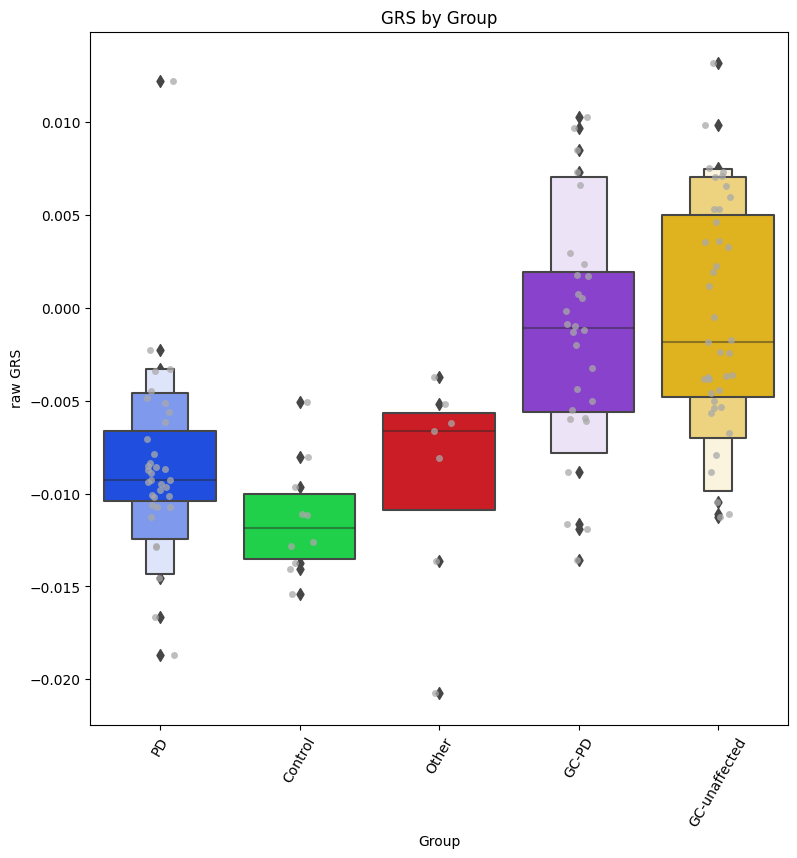

In [15]:
# grouping = 'study_arm'
grouping = 'DX'

# plot raw GRS scores
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    boxenplot(x=grouping,y='GRS', scale='exponential', data=scores_df, 
              k_depth='trustworthy')

    grsplt = stripplot(x=grouping,y='GRS',data=scores_df, alpha=0.75, 
                       jitter=True, color='darkgrey')
    loc, labels = plt.xticks()
    grsplt.set_xticklabels(labels, rotation=60)
    plt.title('GRS by Group', fontsize='large') 
    plt.xlabel('Group')
    plt.ylabel('raw GRS')
    plt.show()

#### standardize the GRS sample scores

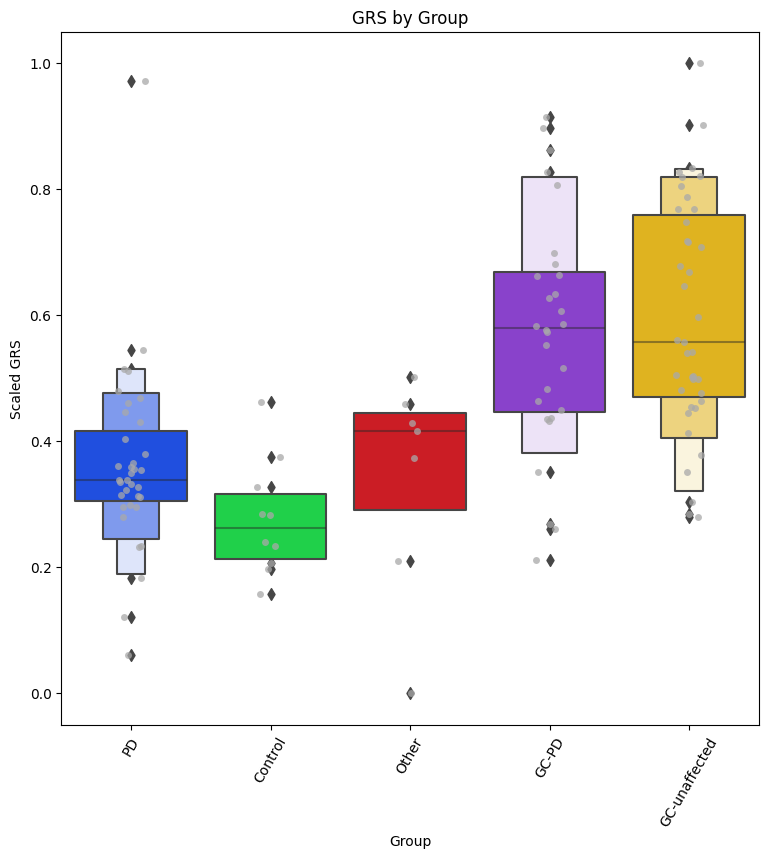

In [16]:
# standardize the GRS sample scores and re-plot
#z-score
scores_df['zGRS'] =  MinMaxScaler().fit_transform(RobustScaler(quantile_range=(25, 75))
                                                  .fit_transform(scores_df[['GRS']]))
if DEBUG:
    display(scores_df.head())

#plot
with rc_context({'figure.figsize': (9, 9), 'figure.dpi': dpi_value}):
    plt.style.use('seaborn-bright')
    boxenplot(x=grouping,y='zGRS', scale='exponential', data=scores_df, 
              k_depth='trustworthy')

    grsplt = stripplot(x=grouping,y='zGRS',data=scores_df, alpha=0.75, 
                       jitter=True, color='darkgrey')
    loc, labels = plt.xticks()
    grsplt.set_xticklabels(labels, rotation=60)
    plt.title('GRS by Group', fontsize='large') 
    plt.xlabel('Group')
    plt.ylabel('Scaled GRS')
    plt.subplots_adjust(wspace=0.3)
    plt.show()

#### saved to the scaled GRS file

In [17]:
scores_df['GRS'] = scores_df['zGRS']
scores_df[['IID', 'DX', 'GRS']].to_csv(grs_scaled_file, index=False)

In [18]:
!date

Mon Feb  6 18:17:34 UTC 2023
